In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Theoretical $q^2$

In [2]:
def dGammaJpsimu(q2):
    return 6.79842*10**(-7) * (0. + (1 + 0.0055125/q2) * ((4.31066 * np.exp(0.038 * q2 + 0.0015 * q2**2) - 0.0448191 * np.exp(0.065 * q2 + 0.0015* q2**2)*np.sqrt((10.106 - q2) * (87.8156 - q2)))**2 + \
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) + 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 * q2 + 0.0041* q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46 *np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (0.0057567 *np.exp(0.094 *q2 + 0.0034 *q2**2) *(10.106 - q2) *(87.8156 - q2))/q2**2)*(1 - 0.011025/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2


def dGammaJpsitau(q2):
    return 6.79842*10**(-7) * (0. + (1 + 1.58064/q2) * ((4.31066 *np.exp(0.038 *q2 + 0.0015* q2**2) - 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)* np.sqrt((10.106 - q2) *(87.8156 - q2)))**2 +\
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) +0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 *q2 + 0.0041 *q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46*np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (1.65066 *np.exp(0.094* q2 + 0.0034 *q2**2)* (10.106 - q2) *(87.8156 - q2))/q2**2)* (1 - 3.16128/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2

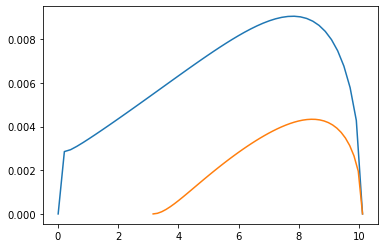

In [3]:
q2_mu = np.linspace(0.105**2, 10.106)
q2_tau = np.linspace(1.778**2, 10.106)

dGmu = dGammaJpsimu(q2_mu)
dGtau = dGammaJpsitau(q2_tau)

plt.plot(q2_mu, dGmu)
plt.plot(q2_tau, dGtau)

## Loading Data

In [4]:
epsilon_pimu = 1/100

# No veto
modes_dt = {0: {'mode': './features/JpsiTauNu_10Noise_NoVeto.root', 'yields': 3.76e3}, 
            1: {'mode': './features/JpsiMuNu_10Noise_NoVeto.root', 'yields': 1.03e5},
            2: {'mode': './features/RJpsiInclusive_10Noise_NoVeto.root', 'yields': 3.83e3},
            3: {'mode': './features/RJpsiCombCascade_10Noise_NoVeto.root', 'yields': 7.89e4},
            4: {'mode': './features/RJpsiMisID_10Noise_NoVeto.root', 'yields': epsilon_pimu*1.10e8}
           }



# # 20noise
# modes_dt = {0: {'mode': './features/JpsiTauNu_20Noise_NoVeto.root', 'yields': 3.65e3}, 
#             1: {'mode': './features/JpsiMuNu_20Noise_NoVeto.root', 'yields': 9.95e4},
#             2: {'mode': './features/RJpsiInclusive_20Noise_NoVeto.root', 'yields': 3.79e3},
#             3: {'mode': './features/RJpsiCombCascade_20Noise_NoVeto.root', 'yields': 7.94e4},
#             4: {'mode': './features/RJpsiMisID_20Noise_NoVeto.root', 'yields': epsilon_pimu*1.10e8}
#            }

In [5]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        print('\rReading:', i)
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        
        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
#         print(len(idx))
        idx = idx[:20000]    # if too much data
#         idx = idx[:5000]    # if too much data
        num_lt.append(len(idx))    

        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(idx)
        print(df_i['weight'][0])
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [6]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

Reading: 0
1.8458517427589594
Reading: 1
19.548301385462135
Reading: 2
22.662721893491124
Reading: 3
44.325842696629216
Reading: 4
55.0
train size: 14629 (50.01%); test size: 14626 (49.99%)
data points per mode:  [2037, 5269, 169, 1780, 20000]


In [7]:
def relabel(x):
    if x == 0:    # tau
        return 0
    elif x == 1:    # mu
        return 1
    else:    # other bkg
        return 2

In [8]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [9]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'pPerpHc', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum',
       'ENeutral03', 'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'q2True', 'miss2True', 'EBTrue', 'pBTrue', 'sMinMuHcVertTrue',
       'target', 'weight'],
      dtype='object')

In [10]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S'
#            ]

features = ['q2', 'miss2',  # check
            'pB', 'EB',  # check
            'pHc', 'EHc', # check 
            'pMu', 'EMu', # check
            'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc',  # check
            'mHcMu', # check
            'pPerp', 'mCorr',  # check
            'D0Max', 'DzMax', 'D0Sum', 'DzSum',  # check
            'ENeutral03','ENeutral06',  # check
            'ENeutral03Hadron', 'ENeutral06Hadron', # check
            'ENeutral03Photon', 'ENeutral06Photon',  # check
            'ECharge03', 'ECharge06', # check
            'ECharge03PV', 'ECharge06PV',  # check
            'ECharge03DV', 'ECharge06DV' # check
           ]

In [11]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

In [12]:
# df_train_o[df_train_o.target==4]['pPerpHc']

## Reweight by $q^2
$

In [13]:
# replace some values that have q2 larger than the max, by the max
# df_train_o.loc[(df_train_o['q2True']>=11) & ((df_train_o.target==0) | (df_train_o.target==1)), 'q2True'] = 10.9
# df_train.loc[(df_train['q2True']>=11) & ((df_train.target==0) | (df_train.target==1)), 'q2True'] = 10.9
# df_test.loc[(df_test['q2True']>=11) & ((df_test.target==0) | (df_test.target==1)), 'q2True'] = 10.9

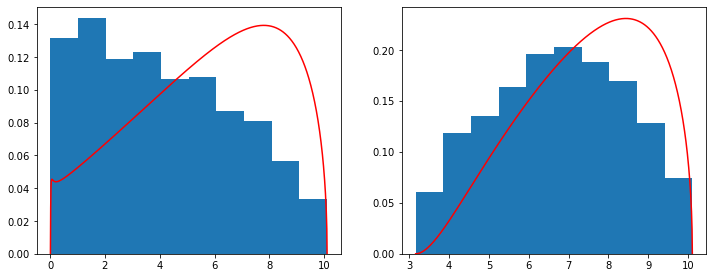

In [14]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 10.106]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaJpsimu(q2_mu)
ax1.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 10.106]
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaJpsitau(q2_tau)
ax2.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

In [15]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [16]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaJpsitau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaJpsimu, df_train_o, target=1, range_=range_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']

df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)


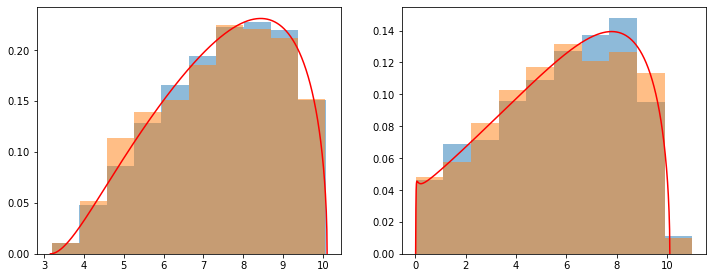

In [17]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

## BDT

In [18]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [19]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.reweight.values);

In [20]:

# scores for training
df_bdt_train_s = df_train[['target', 'reweight']]
df_bdt_train_s.loc[:, 'pred0'] = xgbc1.predict_proba(X_train)[:, 0]
df_bdt_train_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_train)[:, 1]

# score for testing 
df_bdt_test_s = df_test[['target', 'reweight']]
df_bdt_test_s.loc[:, 'pred0'] = xgbc1.predict_proba(X_test)[:, 0]
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]

## Finding the optimal position to cut

In [21]:
df_bdt_train_s_bkg = df_bdt_train_s.copy()
df_bdt_train_s_bkg['pred_sum'] = df_bdt_train_s_bkg['pred0'] + df_bdt_train_s_bkg['pred1']

In [22]:
def bdt_cut_bkg(df, cut, bkg):
    df1 = df[df['pred_sum']>=cut]
    S1 = df1[df1['target'] != bkg]['reweight'].values.sum()    # Number of tau + mu signals
    B1 = df1[df1['target'] == bkg]['reweight'].values.sum()    # Number of bkg.
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1)))


def find_opt_cut_bkg(df_bdt_train_s, step=0.01, bkg=2):
    cuts1 = np.arange(0, 1, step)
    # store cuts 
    c1_lt = []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    snr1 = []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        print("{}/{}".format(i1, len(cuts1)), end='\r')
        res1 = bdt_cut_bkg(df_bdt_train_s, c1, bkg)
        c1_lt.append(c1)

        loss11.append(res1[0]); loss12.append(res1[1])
        snr1.append(res1[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, loss11, loss12, snr1]).T
    df_bdt_loss.columns = ['c1', 'loss11', 'loss12', 'snr1']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    return df_bdt_loss.iloc[df_bdt_loss['tot1'].argmin()][['c1']].values

In [55]:
# c1 = find_opt_cut_bkg(df_bdt_train_s_bkg)
# print()
# print(c1)
c1 = 0.01

In [56]:
df_bdt_train_s_sig = df_bdt_train_s_bkg[df_bdt_train_s_bkg['pred_sum'] > c1]
df_bdt_train_s_sig['pred_diff'] = df_bdt_train_s_sig['pred0'] - df_bdt_train_s_sig['pred1']

In [57]:
def bdt_cut_sig(df, cut1, signal1=0, signal2=1):
    df1 = df[(df['pred_diff'] >= cut1)]    # pass tau cut, not pass mu cut
    df2 = df[(df['pred_diff'] < cut1)]    # pass mu cut, not pass tau cut
    
    S1 = df1[df1['target'] == signal1]['reweight'].values.sum()    # Number of tau signals
    B1 = df1[df1['target'] != signal1]['reweight'].values.sum()    # Number of tau bkg.
    
    S2 = df2[df2['target'] == signal2]['reweight'].values.sum()    # Number of mu signals
    B2 = df2[df2['target'] != signal2]['reweight'].values.sum()    # Number of mu bkg.
    
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1))), ((S2+B2)**0.5, (0.1*B2), S2/(np.sqrt(S2+B2)))

def find_opt_cut_sig(df_bdt_train_s, step=0.01):
    cuts1 = np.arange(-1, 1, step)
    # mu cut
    cuts2 = np.arange(-1, 1, step)

    # store cuts (tau - mu)
    c1_lt = []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    snr1, snr2 = [], []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        print("{}/{}".format(i1, len(cuts1)), end='\r')
        res1, res2 = bdt_cut_sig(df_bdt_train_s, c1)
        c1_lt.append(c1)

        loss11.append(res1[0]); loss12.append(res1[1])
        loss21.append(res2[0]); loss22.append(res2[1])
        snr1.append(res1[2]), snr2.append(res2[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, loss11, loss12, snr1, loss21, loss22, snr2]).T
    df_bdt_loss.columns = ['c1', 'loss11', 'loss12', 'snr1', 'loss21', 'loss22', 'snr2']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    df_bdt_loss['loss2'] = (df_bdt_loss['loss21']**2 + df_bdt_loss['loss22']**2)**0.5
    df_bdt_loss['tot2'] = (df_bdt_loss['loss2'] - df_bdt_loss['loss2'].min())/(df_bdt_loss['loss2'].max() - df_bdt_loss['loss2'].min()) - \
        ((df_bdt_loss['snr2'] - df_bdt_loss['snr2'].min())/(df_bdt_loss['snr2'].max() - df_bdt_loss['snr2'].min()))

    df_bdt_loss['tot'] = df_bdt_loss['tot1'] + df_bdt_loss['tot2']

    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c1']].values

In [59]:
c2 = find_opt_cut_sig(df_bdt_train_s_sig)
print()
print(c2)
# c2 = -0.95

199/200
[-0.95]


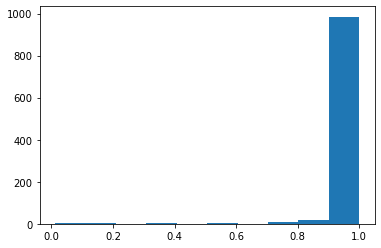

In [61]:
plt.hist(df_bdt_train_s_sig[df_bdt_train_s_sig.target==0]['pred0']);

In [36]:
# apply the cut, to select tau and mu samples
df_bdt_test_s_cut_tau = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] >= c1) & 
                                          (df_bdt_test_s['pred1'] <  c2)]

df_bdt_test_s_cut_mu = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] <  c1) &
                                         (df_bdt_test_s['pred1'] >= c2)]


In [37]:
# Grouping the bkg. types
df_bdt_test_s_cut_tau['target'] = \
            df_test_o.loc[df_bdt_test_s_cut_tau.index]['target']

df_bdt_test_s_cut_mu['target'] = \
            df_test_o.loc[df_bdt_test_s_cut_mu.index]['target']



In [38]:
df_bdt_test_s_cut_tau['q2'] = df_test_o.loc[df_bdt_test_s_cut_tau.index]['q2']
df_bdt_test_s_cut_mu['q2'] = df_test_o.loc[df_bdt_test_s_cut_mu.index]['q2']

df_bdt_test_s_cut_tau['iEvt'] = df_test_o.loc[df_bdt_test_s_cut_tau.index]['iEvt']
df_bdt_test_s_cut_mu['iEvt'] = df_test_o.loc[df_bdt_test_s_cut_mu.index]['iEvt']

In [39]:
np.unique(df_bdt_test_s_cut_mu.target)

array([0, 1, 2, 3, 4])

In [40]:
# separate CombCascade
# 1. change label 4(misID)->5
# 2. change label 3(Comb+Casc)->999
# 3. loop over 999 and change to 3/4 (Comb/Casc)

df_bdt_test_s_cut_tau.loc[df_bdt_test_s_cut_tau.target==4, 'target'] = 5
df_bdt_test_s_cut_mu.loc[df_bdt_test_s_cut_mu.target==4, 'target'] = 5

df_bdt_test_s_cut_tau.loc[df_bdt_test_s_cut_tau.target==3, 'target'] = 999
df_bdt_test_s_cut_mu.loc[df_bdt_test_s_cut_mu.target==3, 'target'] = 999

In [41]:
file = uproot.open('./features/RJpsiComb_0Noise_NoVeto.root')
df_comb = pd.DataFrame(np.array(file['t']['features'].array()))
comb_iEvt = df_comb.iEvt.tolist()

file = uproot.open('./features/RJpsiCascade_0Noise_NoVeto.root')
df_casc = pd.DataFrame(np.array(file['t']['features'].array()))
casc_iEvt = df_casc.iEvt.tolist()



In [42]:
for ie in df_bdt_test_s_cut_tau[df_bdt_test_s_cut_tau.target==999]['iEvt']:
    if (ie in comb_iEvt):
        df_bdt_test_s_cut_tau.loc[(df_bdt_test_s_cut_tau.target==999) & (df_bdt_test_s_cut_tau.iEvt==ie), 'target'] = 3
    elif (ie in casc_iEvt):
        df_bdt_test_s_cut_tau.loc[(df_bdt_test_s_cut_tau.target==999) & (df_bdt_test_s_cut_tau.iEvt==ie), 'target'] = 4
    else:
        print("Did not find such event:", ie)

for ie in df_bdt_test_s_cut_mu[df_bdt_test_s_cut_mu.target==999]['iEvt']:
    if (ie in comb_iEvt):
        df_bdt_test_s_cut_mu.loc[(df_bdt_test_s_cut_mu.target==999) & (df_bdt_test_s_cut_mu.iEvt==ie), 'target'] = 3
    elif (ie in casc_iEvt):
        df_bdt_test_s_cut_mu.loc[(df_bdt_test_s_cut_mu.target==999) & (df_bdt_test_s_cut_mu.iEvt==ie), 'target'] = 4
    else:
        print("Did not find such event:", ie)



Did not find such event: 160734


In [43]:
np.unique(df_bdt_test_s_cut_tau.target)

array([], dtype=int64)

In [44]:
np.unique(df_bdt_test_s_cut_mu.target)

array([  0,   1,   2,   3,   4,   5, 999])

## Calculating the yields

In [45]:
def cal_uncertainty(df, channel, channel_labels):
    n_lt = []
    for i in channel_labels.keys():
        # Select the signal/bkg. 
        dfi = df[df.target==i]
        if len(dfi) == 0:
            ni = 0
        else: 
            # reweighted number 
            ni = dfi.reweight.sum() / (1-tr_te_split)
        # Print out the table
        if i==channel:
            print('(*Signal)  {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        else:
            print('(*Bkg.)    {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        
        n_lt.append(ni)
    # Estimate the Fake-Lambda_c Bkg.
#     n_fakeLambdac = n_lt[1]*0.28/100
#     n_lt.append(n_fakeLambdac)
#     print('(*Bkg.)  {}:\t{:.2e}'.format('Fake-Lambdac', n_fakeLambdac))
    
    
    print('.'*60)
    s = n_lt[channel]    # Number of signals
    b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
    Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
    u = 1/Z    # Uncertainty
    print("# of Siganl ({}):\t{:.2e}".format(channel_labels[channel], s))
    print("# of Bkg. for {}:\t{:.2e}".format(channel_labels[channel], (b-s)))
    print('Significance for {}:\t{:.0f}'.format(channel_labels[channel], Z))
    print('Uncertainty for {}:\t{:.2e} ({:.2e})'.format(channel_labels[channel], u, u))
    print('Uncertainty at {}:\t{:.2e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
    print('S/B for {}:\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
    print('\n'+'='*60+'\n'*5)
    print()
    
    u_10TeraZ = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
    return u, u_10TeraZ

In [46]:
# CHANNEL_LABELS = {0: 'Jspi tau', 1: 'Jpsi mu', 2: 'Inclusive', 3: 'Comb.+Casc', 4: 'MisID'}
CHANNEL_LABELS = {0: 'Jspi tau', 1: 'Jpsi mu', 2: 'Inclusive', 3: 'Comb', 4: 'Casc', 5: 'MisID'}
uFull_tau, uFull_tau10 = cal_uncertainty(df_bdt_test_s_cut_tau, 0, CHANNEL_LABELS)

uFull_mu, uFull_mu10 = cal_uncertainty(df_bdt_test_s_cut_mu, 1, CHANNEL_LABELS)

print("Overall Uncertainty: {:.2e}".format((uFull_mu**2 + uFull_tau**2)**0.5))
print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_mu10**2 + uFull_tau10**2)**0.5))

(*Signal)  Jspi tau:		0.00e+00
(*Bkg.)    Jpsi mu:		0.00e+00
(*Bkg.)    Inclusive:		0.00e+00
(*Bkg.)    Comb:		0.00e+00
(*Bkg.)    Casc:		0.00e+00
(*Bkg.)    MisID:		0.00e+00
............................................................


ZeroDivisionError: division by zero

In [81]:
'{:.4f}'.format(3.26/2.67-1)

'0.2210'

In [82]:
# for q^2 binning (cut=7.15GeV)
def binbybin_correction(df_train, cut=7.15):
    Cs = {}
    for i in np.unique(df_train.target):
        dfi = df_train[df_train.target == i]
        N_q2Low = dfi[dfi.q2 < cut]['reweight'].sum()
        N_q2High = dfi[dfi.q2 >= cut]['reweight'].sum()
        N_q2truthLow = dfi[dfi.q2True < cut]['reweight'].sum()
        N_q2truthHigh = dfi[dfi.q2True >= cut]['reweight'].sum()
        Cs[i] = [N_q2truthLow/N_q2Low, N_q2truthHigh/N_q2High]
    return Cs

In [83]:
Cs = binbybin_correction(df_train, 7.15)
Cs[2] = [1, 1]    # replacing the bins correction for bkg. to 1
Cs[3] = [1, 1]    # replacing the bins correction for bkg. to 1
Cs[4] = [1, 1]    # replacing the bins correction for bkg. to 1
Cs[5] = [1, 1]    # replacing the bins correction for bkg. to 1

Cs

{0: [0.8681075985902256, 1.1142472365417386],
 1: [0.9557716768760559, 1.0912024243077074],
 2: [1, 1],
 3: [1, 1],
 4: [1, 1],
 5: [1, 1]}

In [84]:
def diff_measurement(df, q2_cut, channel, Cs):
#     global dfHigh
    def _cal_uncertainty_(df, channel, channel_labels, Cs, region):
        n_lt = []
        for i in channel_labels.keys():
            # Select the signal/bkg. 
            dfi = df[df.target==i]
            if len(dfi) == 0:
                ni = 0
            else: 
                # reweighted number 
                ni = dfi.reweight.sum() / (1-tr_te_split) * Cs[i][region]
            # Print out the table
            if i==channel:
                print('(*Signal)  {}:\t{:.2e}'.format(channel_labels[i], ni))
            else:
                print('(*Bkg.)    {}:\t{:.2e}'.format(channel_labels[i], ni))

            n_lt.append(ni)
        # Estimate the Fake-J/psi Bkg.
#         n_fakeJpsi = n_lt[1]/.99998*.95*7/95/2
#         n_lt.append(n_fakeJpsi)
#         print('(*Bkg.)    {}:\t{:.2e}'.format('Fake-Jpsi', n_fakeJpsi))


        print('.'*40)
        s = n_lt[channel]    # Number of signals
        b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
        Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
        u = 1/Z    # Uncertainty
        print("# of Siganl ({}):     {:.2e}".format(channel_labels[channel], s))
        print("# of Bkg. for {}:     {:.2e}".format(channel_labels[channel], (b-s)))
        print('Significance for {}:  {:.0f}'.format(channel_labels[channel], Z))
        print('Uncertainty for {}:   {:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
        print('Uncertainty at {}:    {:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
        print('S/B for {}:           {:.2f}'.format(channel_labels[channel], s/(b-s)))
        print('\n'+'='*40)

#         for i in channel_labels.keys():
#             if i == channel:
#                 continue
#             else:
#                 print('{}/B:\t{:.2f}/{:.2f} = {:.2f}%'.format(channel_labels[i], n_lt[i], (b-s), n_lt[i]/(b-s)*100))
#         print('{}/B:\t{:.2f}/{:.2f} = {:.2f}%'.format('Fake-J/psi', n_lt[-1], (b-s), (n_lt[-1])/(b-s)*100))

        u10 = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
        return u, u10
    
    
    dfLow = df[df.q2 < q2_cut]
    dfHigh = df[df.q2 >= q2_cut]
#     print(dfHigh)
    print('#####   q^2 < 7.15   #####')
    print()
    u_Low, u_Low10 = _cal_uncertainty_(dfLow, channel, CHANNEL_LABELS, Cs, 0)
    print()
    print('#####   q^2 >= 7.15   #####')    
    print()
    u_High, u_High10 = _cal_uncertainty_(dfHigh, channel, CHANNEL_LABELS, Cs, 1)
    
    
    
    return u_Low, u_High, u_Low10, u_High10
    

In [85]:
uLow_tau, uHigh_tau, uLow_tau10, uHigh_tau10 = diff_measurement(df_bdt_test_s_cut_tau, 7.15, 0, Cs)

print('\n'*5)

uLow_mu, uHigh_mu, uLow_mu10, uHigh_mu10 = diff_measurement(df_bdt_test_s_cut_mu, 7.15, 1, Cs)

print('\n'*5)

print("Overall Uncertainty (Low):  {:.2e}".format((uLow_tau**2 + uLow_mu**2)**0.5))
print("Overall Uncertainty 10-Tera Z (Low):  {:.2e}".format((uLow_mu10**2 + uLow_tau10**2)**0.5))
print("Overall Uncertainty (High): {:.2e}".format((uHigh_tau**2 + uHigh_mu**2)**0.5))
print("Overall Uncertainty 10-Tera Z (High): {:.2e}".format((uHigh_tau10**2 + uHigh_mu10**2)**0.5))


#####   q^2 < 7.15   #####

(*Signal)  Jspi tau:	1.08e+03
(*Bkg.)    Jpsi mu:	3.18e+02
(*Bkg.)    Inclusive:	0.00e+00
(*Bkg.)    Comb:	6.21e+02
(*Bkg.)    Casc:	3.55e+02
(*Bkg.)    MisID:	4.40e+02
........................................
# of Siganl (Jspi tau):     1.08e+03
# of Bkg. for Jspi tau:     1.73e+03
Significance for Jspi tau:  19
Uncertainty for Jspi tau:   5.20052e-02 (5.20e-02)
Uncertainty at 10 TeraZ:    1.64455e-02 (1.64e-02)
S/B for Jspi tau:           0.62


#####   q^2 >= 7.15   #####

(*Signal)  Jspi tau:	1.81e+03
(*Bkg.)    Jpsi mu:	7.03e+02
(*Bkg.)    Inclusive:	1.36e+02
(*Bkg.)    Comb:	2.66e+02
(*Bkg.)    Casc:	0.00e+00
(*Bkg.)    MisID:	2.20e+02
........................................
# of Siganl (Jspi tau):     1.81e+03
# of Bkg. for Jspi tau:     1.32e+03
Significance for Jspi tau:  30
Uncertainty for Jspi tau:   3.35495e-02 (3.35e-02)
Uncertainty at 10 TeraZ:    1.06093e-02 (1.06e-02)
S/B for Jspi tau:           1.37







#####   q^2 < 7.15   #####

(*Bkg.

## Saving Plots

In [47]:
df_plot = df_test
# df_plot = pd.concat([df_train, df_test])

error for tau mode:  1.69
error for mu mode: 1.58


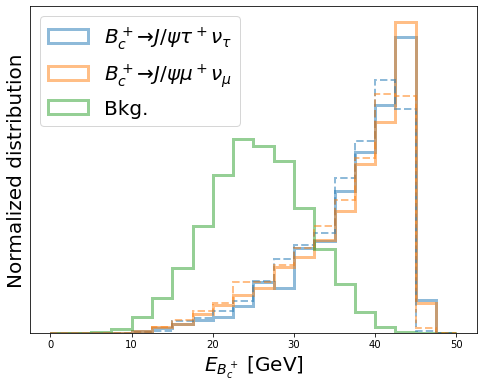

In [48]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,50]

ax1.hist(df_plot[(df_plot.target==0)]['EB'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['EB'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['EB'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['EBTrue'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['EBTrue'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$E_{B_c^+}$ [GeV]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/JpsiE')
# f.savefig('./figures/JpsiE_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['EB']
X_mea1 = df_plot[(df_plot.target==1)]['EB']
X_tru0 = df_plot[(df_plot.target==0)]['EBTrue']
X_tru1 = df_plot[(df_plot.target==1)]['EBTrue']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


error for tau mode:  1.84
error for mu mode: 1.89


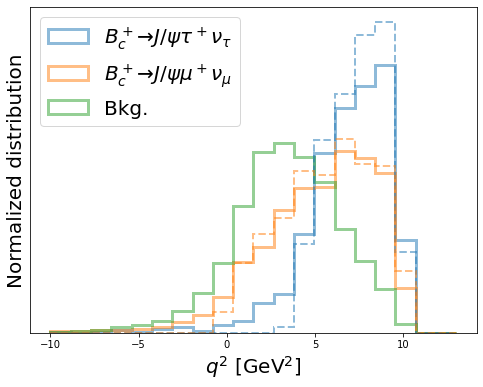

In [49]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-10,13]

ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Jpsisq2')
# f.savefig('./figures/Jpsiq2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


error for tau mode:  1.95
error for mu mode: 2.20


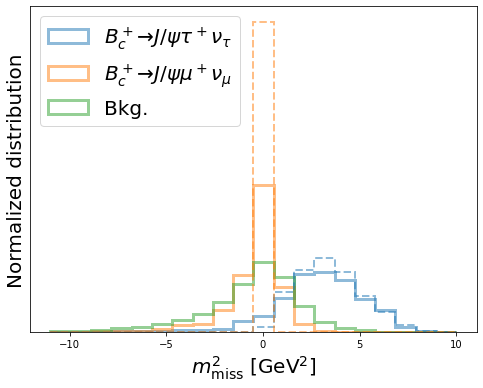

In [50]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-11,10]


ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Jpsismiss2')
# f.savefig('./figures/Jpsimiss2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))



In [49]:
df_plot.loc[df_test_o.index, 'target'] = df_test_o.loc[df_test_o.index]
# df_plot.loc[df_train_o.index, 'target'] = df_train_o.loc[df_train_o.index]
df_plot.loc[df_test.index, 'reweight'] = df_test.reweight
# df_plot.loc[df_train.index, 'reweight'] = df_train.reweight

In [50]:
# separate CombCascade
# 1. change label 4(misID)->5
# 2. change label 3(Comb+Casc)->999
# 3. loop over 999 and change to 3/4 (Comb/Casc)

df_plot.loc[df_plot.target==4, 'target'] = 5
df_plot.loc[df_plot.target==3, 'target'] = 999


In [51]:
for ie in df_plot[df_plot.target==999]['iEvt']:
    if (ie in comb_iEvt):
        df_plot.loc[(df_plot.target==999) & (df_plot.iEvt==ie), 'target'] = 3
    elif ie in [160734, 761722, 1410482, 2192763, 2447002, 4158740, 2579758, 3517198, 2690601]:
        df_plot.loc[(df_plot.target==999) & (df_plot.iEvt==ie), 'target'] = 3
    elif (ie in casc_iEvt):
        df_plot.loc[(df_plot.target==999) & (df_plot.iEvt==ie), 'target'] = 4
    else:
        print("Did not find such event:", ie)


In [52]:
len(df_plot[df_plot.target==4])

22

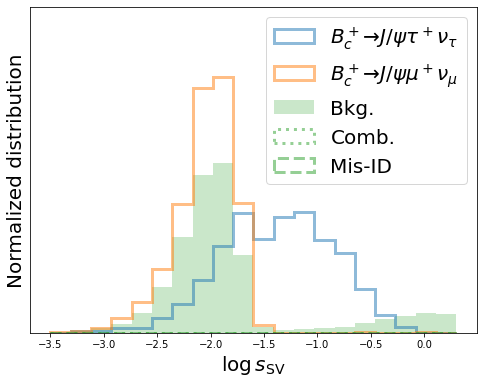

In [51]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3.5,0.3]
# range_=[-3.5,3]


ax1.margins(y=0.275)
ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, lw=3, label=r'Bkg.', alpha=0.25);
# ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuHcVert']), weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label='Comb.', alpha=0.5, color='C2', linestyle=':');
ax1.hist(np.log10(df_plot[(df_plot.target==5)]['sMinMuHcVert']), weights=df_plot[df_plot.target==5]['reweight']/sum(df_plot[df_plot.target==5]['reweight']), bins=20, range=range_, histtype='step', lw=3, label='Mis-ID', alpha=0.5, color='C2', linestyle='--');


ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsilogssv')
# f.savefig('./figures/Jpsilogssv_20noise')


In [54]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[-3.5,0.3]


# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# # ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);


# # ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# # ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normalized distribution', fontsize=20)
# ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
# ax1.set_yticks([])
# ax1.legend(loc=1, fontsize=20)


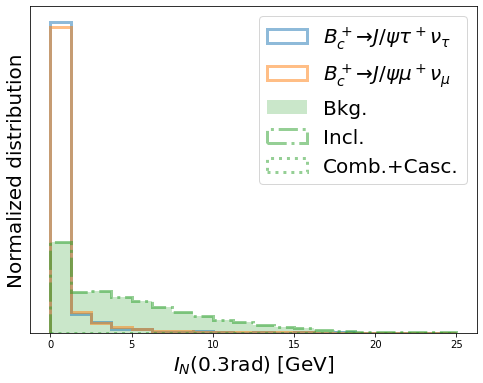

In [52]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]


ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5);
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, lw=3, label=r'Bkg.', alpha=0.25);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Incl.', alpha=0.5, linestyle='-.', color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Comb.+Casc.', alpha=0.5, linestyle=':', color='C2');
# ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Comb.+Casc.', alpha=0.5, linestyle='--', color='C2');


ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsiisolation')


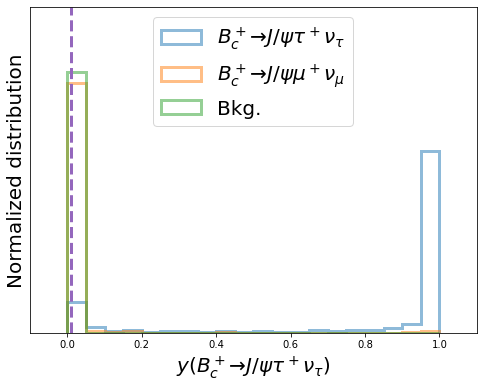

In [54]:

df_plot = df_bdt_test_s
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
pred0_max = df_plot['pred0'].max() 
pred0_min = df_plot['pred0'].min() 
pred0_diff = pred0_max - pred0_min
# range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]
# range_=[-0.04,1.04]
range_=[0,1]
# print(range_)

ax1.margins(y=0.25)
ax1.margins(x=0.1)

bins_ = 20

ax1.hist(df_plot[(df_plot.target==0)]['pred0'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred0'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['pred0'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$y(B_c^+\to J/\psi \tau^+\nu_\tau)$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.axvline(c1, color='C4', lw=3, linestyle='--')

# f.savefig('./figures/JpsitauBDT')


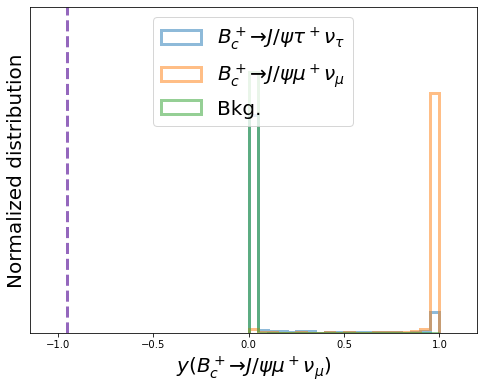

In [53]:

df_plot = df_bdt_test_s
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
pred0_max = df_plot['pred1'].max() 
pred0_min = df_plot['pred1'].min() 
pred0_diff = pred0_max - pred0_min
range_=[0,1]
# print(range_)

ax1.margins(y=0.25)
ax1.margins(x=0.1)
bins_ = 20

ax1.hist(df_plot[(df_plot.target==0)]['pred1'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred1'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['pred1'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$y(B_c^+\to J/\psi \mu^+\nu_\mu)$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.axvline(c2, color='C4', lw=3, linestyle='--')

# f.savefig('./figures/JpsimuBDT')


error for tau mode:  3.00
error for mu mode: 2.93


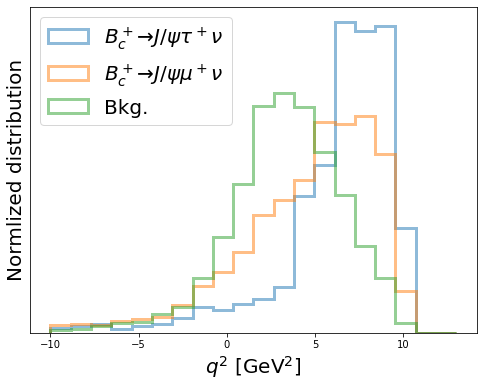

In [34]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-10,13]

ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Jpsisq2')
f.savefig('./figures/Jpsiq2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


error for tau mode:  4.27
error for mu mode: 4.66


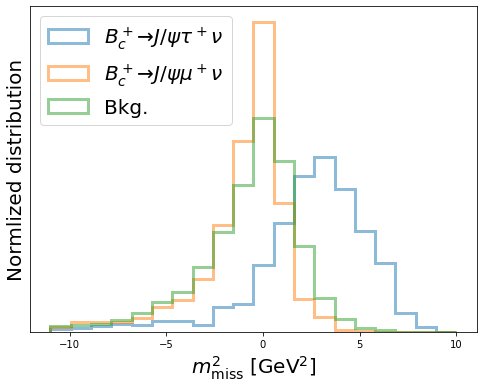

In [35]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-11,10]


ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Jpsismiss2')
f.savefig('./figures/Jpsimiss2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))



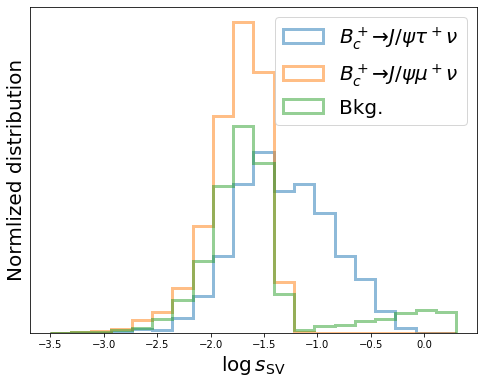

In [36]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3.5,0.3]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);


# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsilogssv')
f.savefig('./figures/Jpsilogssv_20noise')


In [ ]:

# score for testing 
df_bdt_test_s = df_test[['target', 'reweight']]
df_bdt_test_s.loc[:, 'pred0'] = soft(xgbc1.predict_proba(X_test), 0)
df_bdt_test_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_test), 1)

In [25]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))
# R(Jpsi)

{'sMinMuHcVert': 969.0,
 'miss2': 881.0,
 'pB': 795.0,
 'sMinMuTr': 739.0,
 'sPVHc': 686.0,
 'mCorr': 657.0,
 'pHc': 599.0,
 'mHcMu': 588.0,
 'sMinHcTr': 542.0,
 'q2': 497.0,
 'pMu': 352.0,
 'ECharge03': 318.0,
 'pPerp': 312.0,
 'ECharge06': 262.0,
 'ENeutral03': 250.0,
 'D0Max': 201.0,
 'ECharge06PV': 199.0,
 'ENeutral06': 197.0,
 'ECharge06DV': 191.0,
 'DzMax': 144.0,
 'ENeutral06Photon': 134.0,
 'DzSum': 133.0,
 'D0Sum': 116.0,
 'ENeutral03Photon': 115.0,
 'ENeutral06Hadron': 59.0,
 'ECharge03DV': 44.0,
 'EHc': 38.0,
 'ENeutral03Hadron': 33.0,
 'ECharge03PV': 24.0,
 'EB': 1.0}

In [27]:
df_test['sMinMuHcVert']

0        0.012823
1        0.021189
2        0.046108
3        0.205834
4        0.203519
           ...   
54597    0.013388
54598    0.438956
54599    0.014942
54600    0.004887
54601    0.015372
Name: sMinMuHcVert, Length: 54602, dtype: float32

In [35]:
# df_plot = df_test.loc[df_test_o[df_test_o['target']!=4].index]
df_plot = df_test.loc[df_test_o[df_test_o['target']!=4].index]
df_plot = df_test


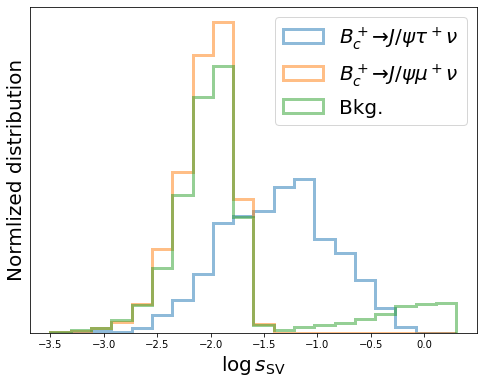

In [41]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3.5,0.3]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Jpsilogssv')
# f.savefig('./figures/Jpsilogssv_20noise')


NameError: name 'df_plot' is not defined

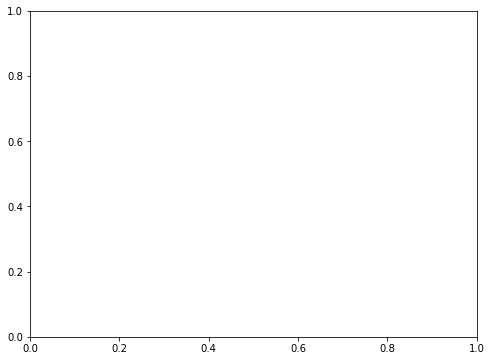

In [26]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3.5,2]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsilogssv')
# f.savefig('./figures/Jpsilogssv_20noise')


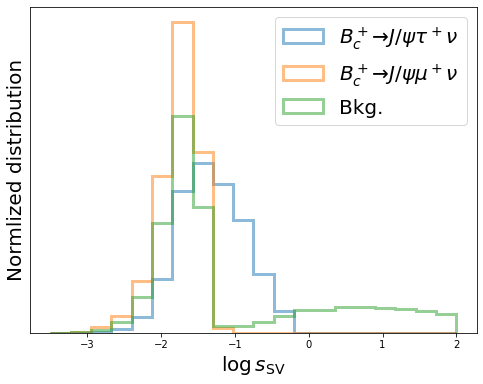

In [49]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3.5,2]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsilogssv')
# f.savefig('./figures/Jpsilogssv_20noise')


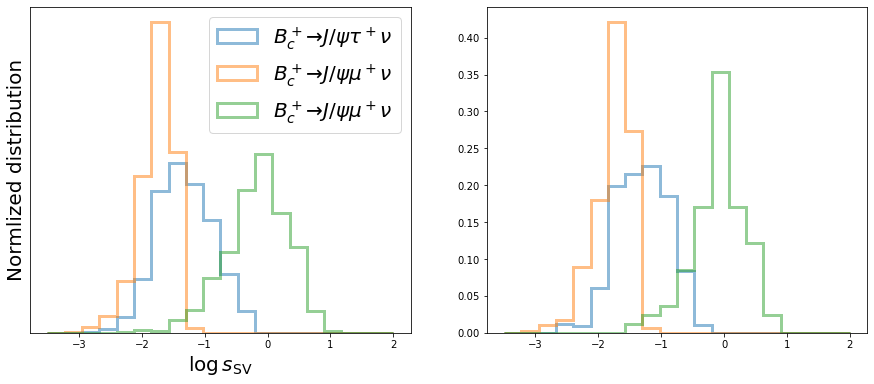

In [94]:
df_plot = df_test

f = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
range_=[-3.5,2]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax1.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuHcVert']), weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuHcVert']), weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax1.hist(np.log10(df_plot[(df_plot.target!=4)]['sMinMuHcVert']), weights=df_plot[df_plot.target!=4]['reweight']/sum(df_plot[df_plot.target!=4]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

df_plot['target'] = df_test_o.loc[df_plot.index]['target']
df_plot = df_plot[df_plot['sMinHcTr']>0.02]
df_plot = df_plot[df_plot['sMinMuTr']>0.02]

ax2.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5);
ax2.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax2.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuHcVert']), weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
ax2.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuHcVert']), weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax2.hist(np.log10(df_plot[(df_plot.target!=4)]['sMinMuHcVert']), weights=df_plot[df_plot.target!=4]['reweight']/sum(df_plot[df_plot.target!=4]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5);
# ax2.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['sMinMuHcVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Jpsilogssv')
# f.savefig('./figures/Jpsilogssv_20noise')


[]

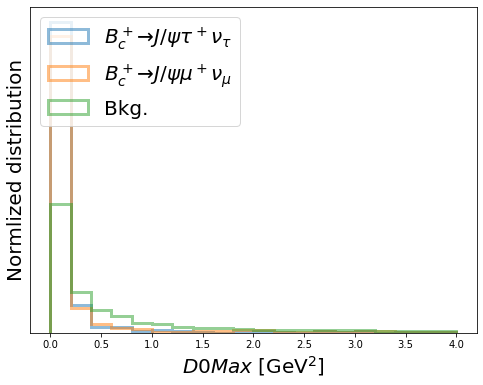

In [54]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,4]


ax1.hist(df_plot[(df_plot.target==0)]['D0Max'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['D0Max'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['D0Max'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$D0Max$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


[]

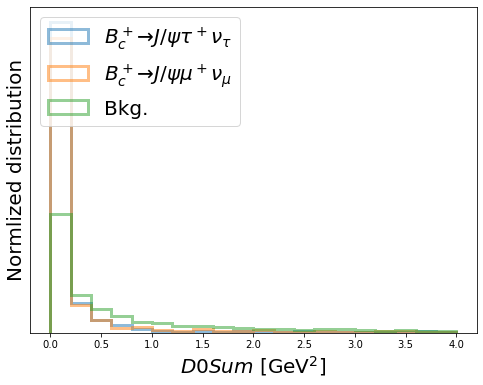

In [55]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,4]


ax1.hist(df_plot[(df_plot.target==0)]['D0Sum'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['D0Sum'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['D0Sum'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$D0Sum$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


[]

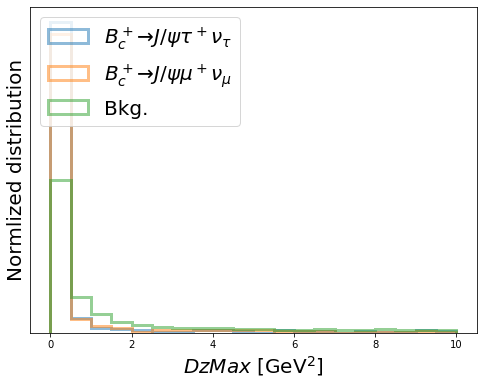

In [58]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,10]


ax1.hist(df_plot[(df_plot.target==0)]['DzMax'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['DzMax'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['DzMax'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=2, fontsize=20)

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$DzMax$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


[]

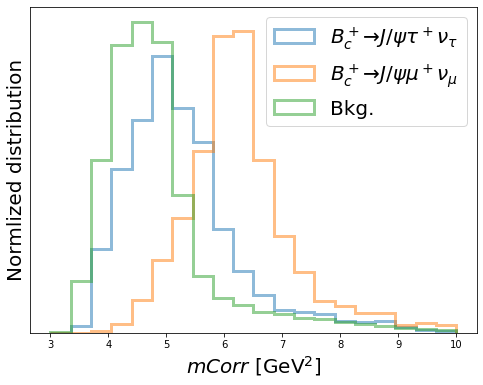

In [67]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[3,10]


ax1.hist(df_plot[(df_plot.target==0)]['mCorr'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['mCorr'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['mCorr'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=1, fontsize=20)

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$mCorr$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


[]

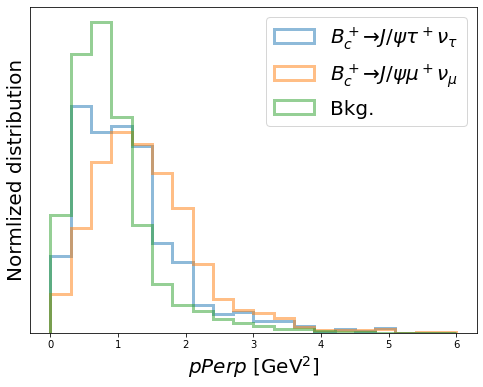

In [68]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,6]


ax1.hist(df_plot[(df_plot.target==0)]['pPerp'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu_\tau$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['pPerp'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu_\mu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['pPerp'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.legend(loc=1, fontsize=20)

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$pPerp$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


In [19]:
df_plot = df_train
X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


error for tau mode:  1.98
error for mu mode: 1.83


In [20]:
df_plot = df_test
X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


error for tau mode:  1.84
error for mu mode: 1.89
